In [1]:
import os

import pandas as pd
import numpy as np

from keras import layers
from keras import models
from keras.preprocessing import image
import matplotlib.pyplot as plt
import time

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
samuel_images_validation_dir = 'data/samuel_images_validation'
samuel_images_train_dir = 'data/samuel_images_train'

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(400, 600, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 398, 598, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 199, 299, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 197, 297, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 98, 148, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 146, 128)      73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 73, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 71, 128)       147584    
__________

In [5]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        samuel_images_train_dir,
        target_size=(400, 600),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        samuel_images_validation_dir,
        target_size=(400, 600),
        batch_size=20,
        class_mode='binary')

Found 896 images belonging to 2 classes.
Found 383 images belonging to 2 classes.


In [7]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
  6/100 [>.............................] - ETA: 10:50 - loss: 0.8040 - acc: 0.5354

/usr/local/lib/python3.6/site-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


100/100 [==============================] - 728s 7s/step - loss: 0.6729 - acc: 0.5783 - val_loss: 0.6105 - val_acc: 0.6211
Epoch 2/30
100/100 [==============================] - 716s 7s/step - loss: 0.6335 - acc: 0.6249 - val_loss: 0.5471 - val_acc: 0.7360
Epoch 3/30
100/100 [==============================] - 716s 7s/step - loss: 0.6131 - acc: 0.6696 - val_loss: 0.4854 - val_acc: 0.8230
Epoch 4/30
100/100 [==============================] - 714s 7s/step - loss: 0.5806 - acc: 0.6946 - val_loss: 0.4415 - val_acc: 0.8437
Epoch 5/30
100/100 [==============================] - 716s 7s/step - loss: 0.5678 - acc: 0.7045 - val_loss: 0.4222 - val_acc: 0.8344
Epoch 6/30
100/100 [==============================] - 715s 7s/step - loss: 0.5552 - acc: 0.7139 - val_loss: 0.4485 - val_acc: 0.8033
Epoch 7/30
100/100 [==============================] - 718s 7s/step - loss: 0.5446 - acc: 0.7279 - val_loss: 0.5295 - val_acc: 0.6801
Epoch 8/30
100/100 [==============================] - 715s 7s/step - loss: 0.532

### Save Model

In [18]:
model_file = 'data/samuel_images_model_{}.h5'.format(time.time())
model.save(model_file)

print('saved to {}'.format(model_file))

saved to data/samuel_images_model_1533233544.758017.h5


### Plot The ROC

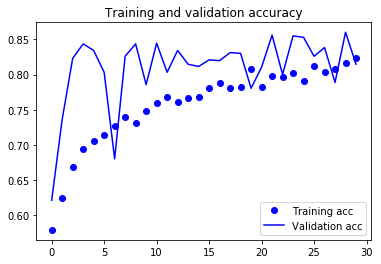

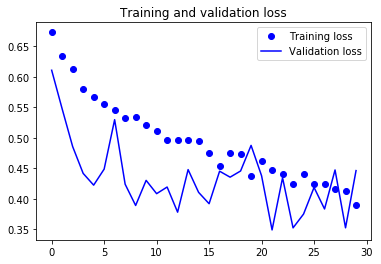

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Validate model

In [10]:
samuel_images_test_dir = 'data/samuel_images_test'

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        samuel_images_test_dir,
        target_size=(400, 600),
        batch_size=20,
        class_mode='binary')

Found 46 images belonging to 2 classes.


In [12]:
loss, acc = model.evaluate_generator(test_generator)
print('loss={}, acc={}'.format(loss, acc))

loss=1.5796463619107786, acc=0.4565217482007068


### Display predicted items

In [13]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [14]:
predictions = model.predict_generator(test_generator)

In [15]:
test_image_results = pd.DataFrame({
    'prediction': predictions.flatten(),
    'filename': test_generator.filenames
}) \
.sort_values('prediction', ascending=False) \
.head(n=10)

In [19]:
test_image_results

,filename,prediction
30,samuel/1645.jpg,0.977103
9,notSamuel/55.jpg,0.856937
25,samuel/11412.jpg,0.833892
33,samuel/3021.jpg,0.806675
22,notSamuel/89.jpg,0.725071
26,samuel/13279.jpg,0.716356
29,samuel/1613.jpg,0.705682
8,notSamuel/5.jpg,0.624777
34,samuel/37080.jpg,0.549309
0,notSamuel/11.jpg,0.547353


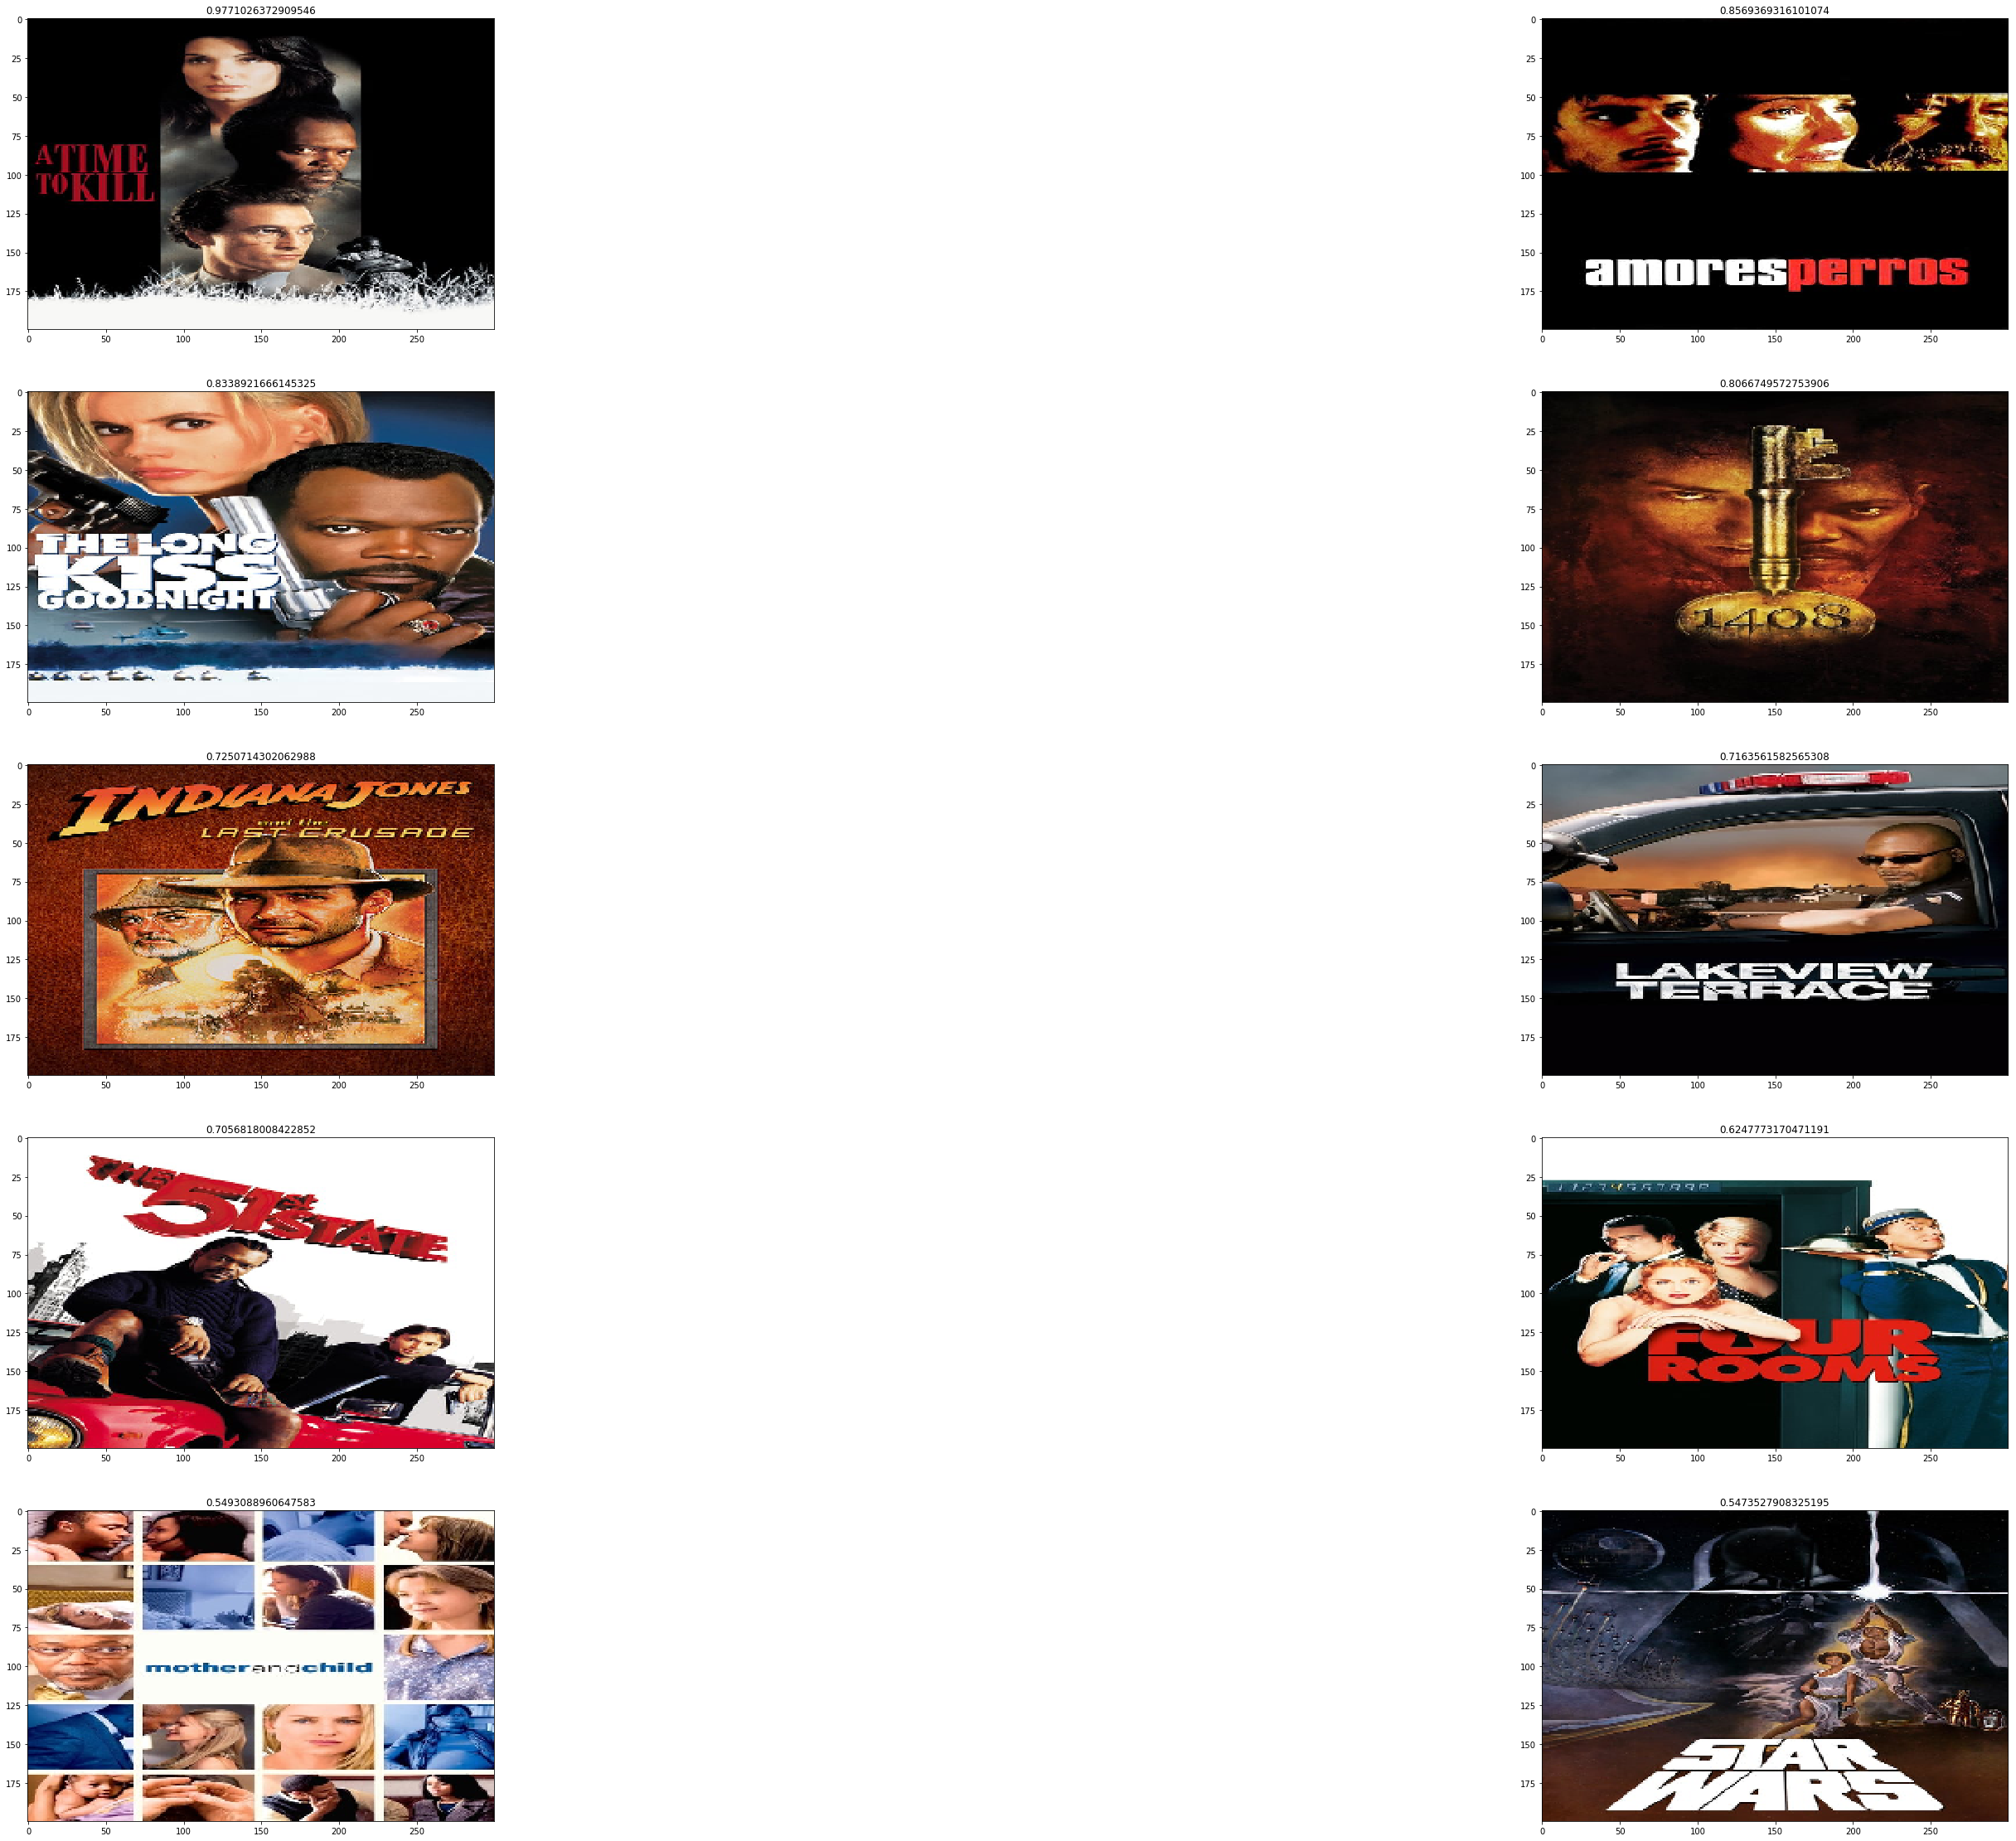

In [16]:
fnames = [os.path.join(samuel_images_test_dir, fname) for fname in test_image_results.filename]

imgs = [image.load_img(fname, target_size=(200,300)) for fname in fnames]
show_images(imgs, 5, test_image_results.prediction)

In [17]:
# Use Grid Search to use all cores https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
